# Algorithms For Startup Founders



Chang Sau Sheong  
SP Digital  
sausheong@gmail.com  
@sausheong

# How to hire the best engineers?

This is one of the most often asked questions I get from startup founders, both tech and non-tech. This problem is a multi-faceted one and my answer is normally _"it's complicated"_ and it certainly is. It's often compounded in a startup where funds are scarce so you need to make sure your hire counts.

There is a famous problem in mathematics called the _secretary problem_ (it's also known as the 37% rule and had many other names throughout its history) that provides an interesting answer to this question.

# The secretary problem

The problem goes this way:

* You have a pool of candidates to hire for a secretary (in our case, a software engineer)
* There is only 1 position to fill you want the best (of course)
* You can interview the candidates one at a time and after each interview you can rank the candidate
* However after each interview you must decide to hire her or not
* If you don't hire her, she will be hired by someone else (probably a competitor)

How do you make this decision? 

# The solution (sort of)

According to the solution to the secretary, you just need to hire the best engineer after **X** number of interviews.

But what is the magical number **X**?

Let's do a _Monte Carlo_ simulation and figure this out.

In [1]:
from cycler import cycler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# number of applicants
size = 100
# iteration size used in simulation
iterations = 1000

results = []
# firstn is the number of applicants to interview before 
# choosing the first one that is better than the best so far
firstn = 1
while firstn < size+1:
    nums = 0
    n = 0
    while n < iterations:
        array = np.random.permutation(size)
        fa = array[0:firstn]
        best = min(fa)
        nextn = firstn
        while nextn < size:
            if array[nextn] < best:
                if array[nextn] == 0:
                    nums += 1
                else:
                    break                    
            nextn += 1        
        n += 1
    results.append([firstn, nums])
    firstn += 1
    
res = pd.DataFrame(results)

# The 37% rule

The name says it all. It has been mathematically proven that the answer is 1/e (where e is Euler's number, a mathematical constant, with the value approximately 2.71828).

1/2.71828 = 0.3678 or approximately 37%.

Let's see how this looks like.

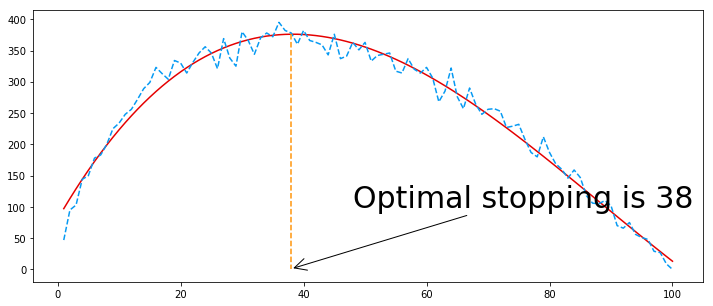

In [13]:
%matplotlib inline
plt.figure(figsize=(12,5))
plt.rc('axes', prop_cycle=(cycler('color', ['xkcd:red', 'xkcd:azure', 'xkcd:tangerine']) + cycler('linestyle', ['-', '--', '--'])))
z = np.polyfit(res[0], res[1], 3)
p = np.poly1d(z)
max_idx = np.argmax(p(res[0]))
opt = res[0][max_idx]
plt.plot(res[0], p(res[0]))
plt.plot(res[0], res[1])
plt.plot([res[0][max_idx],res[0][max_idx]], [p(res[0][max_idx]), 0])
plt.annotate("Optimal stopping is %s"%opt, xy=(opt, 1), xytext=(opt + 10, 100), arrowprops=dict(arrowstyle='->'), size=30)

# The short and sweet answer

To have the highest probability of hiring the best engineer, hire the best you can find after going through 37% of the candidates

# Which problem should you deal with first?

As a startup founder you'll often be doing a gazillion things at the same time. Everything demands your attention and needs to be done and resolved quickly and there is never enough time. Are there any algorithms that can help you determine which task to take care of first?


# Single-machine scheduling problem

There is a class of algorithms for a problem called the single-machine (that's _you_) scheduling problem. The basic premise is that as there are a number of tasks to be done, each with a weight (level of importance), duration (how long it will take to complete the task) and due date (when it needs to be completed).

# What's important to you?

While ideally you should have time to deal with all the tasks, in the real world, you often don't have the luxury of dealing with all the problems effectively every time. In other words, you want to maximise on what's important to you:
* How many tasks do you want to complete within the deadline?
* Solve the biggest problems within the deadline?
* Minimize the lateness of each task?

# Monte Carlo simulation

In this simulation, I'll take a few (relatively simple) well-known algorithms and we'll see how we use the best algorithm to use. We'll be using Monte Carlo method to generate random tasks and get our algorithms to compete with each other. This is a simple simulation so the tasks are assumed to be totally independent of one another.

In [232]:
from collections import namedtuple
from random import shuffle
from random import randint
import random as rnd
import numpy as np
import matplotlib.pyplot as plt

Task = namedtuple('Task', 'weight duration due')

def add(a, b): return tuple(map(lambda x, y: x + y, a, b))
def divide(a, b): return tuple([x/b for x in a])
def duration(task): return task.duration
def weight(task): return task.weight
def due(task): return task.due
def total_duration(tasks): return sum(list(map(duration, tasks)))
def total_weight(tasks): return sum(list(map(weight, tasks)))


# Create random tasks

We will create random tasks for the simulation. The weight and duration are random, but the due date is randomly after an existing due date. We don't want a cluster of tasks around the same time!

In [233]:
# create random tasks
def create_tasks(num): 
    tasks = []
    for i in range(num):
        w, d, u = randint(1,10), randint(1,10)*10, randint(1,10)*10
        # randomly choose a previous task and add its due date to this due date
        # to make this due date after that task
        if i > 0:
            u += tasks[randint(1,i)-1].due
        t = Task(weight=w, duration=d, due=u)        
        tasks.append(t)  
    return tasks

# Tallying up

We have a function to tally up the 3 main metrics we want to measure:
* Percentage of completed tasks over all tasks
* Percentage of completed task weights over all weights
* Lateness of completed tasks


In [234]:
# calculates completedness, weight and lateness
def tally(completed_tasks, all_tasks):
    completed = len(completed_tasks)/len(all_tasks)
    weight = total_weight(completed_tasks)/total_weight(all_tasks)
    duration_all_tasks = total_duration(tasks)
    lateness = 0
    for i in range(len(completed_tasks)):
        elapsed_time = total_duration(completed_tasks[0:i+1])               
        lateness = elapsed_time - completed_tasks[i].due        
    return (completed, weight, lateness)

# The basic algorithms

The benchmark or control algorithm is always no algorithm. In other words, simply flip a coin and choose a task at random to do. 

The first 3 algorithms to maximises the 3 metrics that are important to you:

* Faster tasks first -- do the faster tasks first
* Important tasks first -- do the more important tasks first
* Due tasks first -- do the tasks that are due first



In [235]:
def flip_a_coin(deadline_ratio, *tasks):
    task_list = list(tasks)
    shuffle(task_list)
    deadline = deadline_ratio * total_duration(tasks)
    completed_tasks = []
    time_taken = 0
    for task in task_list:
        time_taken += task.duration
        if time_taken <= deadline:
            completed_tasks.append(task)
        else:
            break
    
    return tally(completed_tasks, tasks)

In [236]:
def faster_tasks_first(deadline_ratio, *tasks):
    sorted_list = sorted(tasks, key=lambda x: x.duration)   
    deadline = deadline_ratio * total_duration(tasks)
    completed_tasks = []
    time_taken = 0
    for task in sorted_list:
        time_taken += task.duration
        if time_taken <= deadline:
            completed_tasks.append(task)
        else:
            break
    
    return tally(completed_tasks, tasks)

In [237]:
def important_tasks_first(deadline_ratio, *tasks):
    sorted_list = sorted(tasks, key=lambda x: x.weight, reverse=True)   
    deadline = deadline_ratio * total_duration(tasks)
    completed_tasks = []
    time_taken = 0
    for task in sorted_list:
        time_taken += task.duration
        if time_taken <= deadline:
            completed_tasks.append(task)
        else:
            break
    
    return tally(completed_tasks, tasks)

In [238]:
def due_tasks_first(deadline_ratio, *tasks):
    sorted_list = sorted(tasks, key=lambda x: x.due)
    deadline = deadline_ratio * total_duration(tasks)
    completed_tasks = []
    time_taken = 0
    for task in sorted_list:
        time_taken += task.duration
        if time_taken <= deadline:
            completed_tasks.append(task)
        else:
            break
    
    return tally(completed_tasks, tasks)

# Running the experiment

Now let's run the experiment. Let's assume that we will not have enough time to do all tasks, so some tasks will have to be abandoned at the end of the experiment. 

The `ratio` is the percentage of the overall duration to run all tasks. In our experiment we used `0.75` meaning we will only run this for 75% of the overall duration for all tasks to finish.

We will also run this over 1000 iterations to iron out potential outlier data.

In [302]:
fn = [
    flip_a_coin,
    faster_tasks_first,
    important_tasks_first,
    due_tasks_first,
]

# deadline ratio
ratio = 0.75
# number of iterations to run
iterations = 1000

final_results = [(0,0,0)] * len(fn)
results = [(0,0,0)] * len(fn)

for i in range(iterations):
    tasks = create_tasks(10)
    for n in range(len(fn)):
        results[n] = fn[n](ratio, *tasks)
        final_results[n] = add(final_results[n], results[n])

(0.5, 1.0)

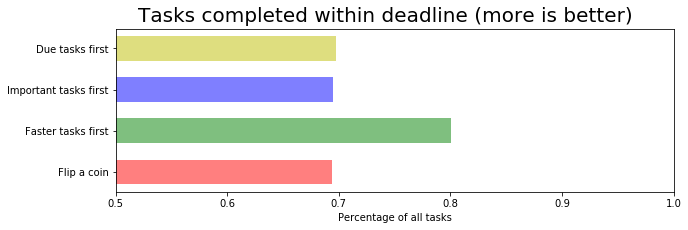

In [308]:
%matplotlib inline

labels = ('Flip a coin', 'Faster tasks first', 'Important tasks first', 'Due tasks first')
y_pos = np.arange(len(labels))

# Which algorithm completes the most tasks in a limited timeline?
f1 = plt.figure(1, figsize=(10,3))
f1.suptitle('No of tasks completed (more is better)', fontsize=20)
plt.barh(y_pos, [i[0]/iterations for i in final_results[0:4]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Percentage of all tasks')
plt.xlim([0.5,1.0])

(0.5, 1.0)

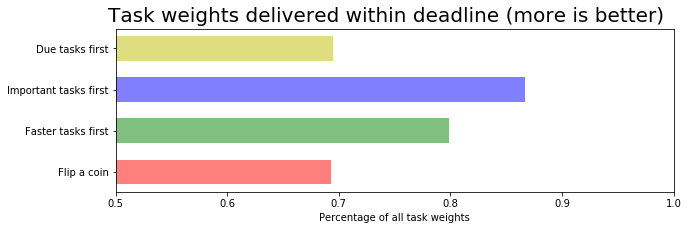

In [307]:
# Which algorithm delivers the most 'weight' (importance) in a limited timeline?
f2 = plt.figure(2, figsize=(10,3))
f2.suptitle('Task weights delivered (more is better)', fontsize=20)
plt.barh(y_pos, [i[1]/iterations for i in final_results[0:4]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Percentage of all task weights')
plt.xlim([0.5,1.0])

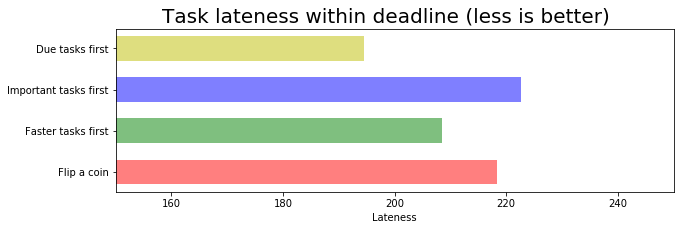

In [306]:
# Which algorithm minimizes lateness in a limited timeline?
f3 = plt.figure(3, figsize=(10,3))
f3.suptitle('Task lateness (less is better)', fontsize=20)
plt.barh(y_pos, [i[2]/iterations for i in final_results[0:4]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Lateness')
plt.xlim([150,250])
plt.show()

# Do the important and fast tasks first

Let's move on to a slightly more complicated algorithm, What if you want to look at the important tasks that can be done faster, first?

In [262]:
def weighted_faster_tasks_first(deadline_ratio, *tasks):
    sorted_list = sorted(tasks, key=lambda x: x.weight/x.duration, reverse=True)   
    deadline = deadline_ratio * total_duration(tasks)
    completed_tasks = []
    time_taken = 0
    for task in sorted_list:
        time_taken += task.duration
        if time_taken <= deadline:
            completed_tasks.append(task)
        else:
            break
    
    return tally(completed_tasks, tasks)

In [263]:
fn = [
    flip_a_coin,
    faster_tasks_first,
    important_tasks_first,
    due_tasks_first,
    weighted_faster_tasks_first
]

final_results = [(0,0,0)] * len(fn)
results = [(0,0,0)] * len(fn)

for i in range(iterations):
    tasks = create_tasks(10)
    for n in range(len(fn)):
        results[n] = fn[n](ratio, *tasks)
        final_results[n] = add(final_results[n], results[n])
        
labels = ('Flip a coin', 'Faster tasks first', 'Important tasks first', 'Due tasks first', 'Weighted fast tasks first')
y_pos = np.arange(len(labels))




In [295]:
%%capture
figure = plt.figure(figsize=(15, 4.5))

ax1 = plt.subplot(1, 3, 1)
ax1.set_title('No of tasks completed', fontsize=15)
plt.barh(y_pos, [i[0]/iterations for i in final_results[0:5]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Percentage of all tasks')
plt.xlim([0.5,1.0])

ax2 = plt.subplot(1, 3, 2)
ax2.set_title('Task weights delivered', fontsize=15)
plt.barh(y_pos, [i[1]/iterations for i in final_results[0:5]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Percentage of all task weights')
plt.xlim([0.5,1.0])

ax3 = plt.subplot(1, 3, 3)
ax3.set_title('Task lateness', fontsize=15)
plt.barh(y_pos, [i[2]/iterations for i in final_results[0:5]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Lateness')
plt.xlim([150,250])
plt.tight_layout()


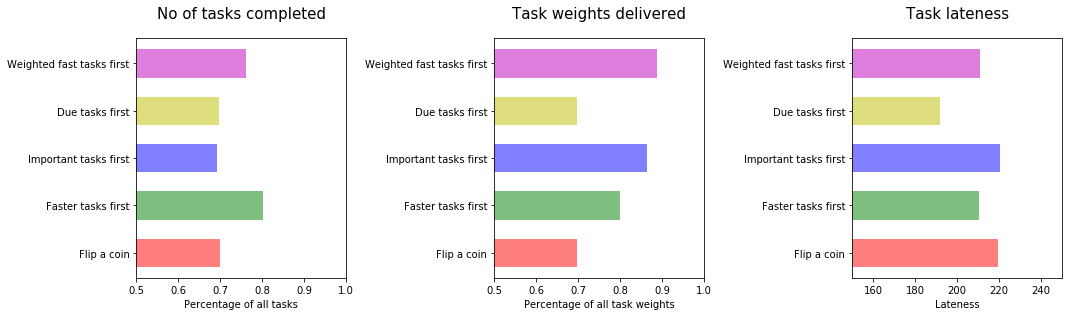

In [296]:
figure

# Do the important and due tasks first

What if you want to look at the important tasks that due earlier, first?

In [297]:
def weighted_due_tasks_first(deadline_ratio, *tasks):
    sorted_list = sorted(tasks, key=lambda x: x.weight/x.due, reverse=True)   
    deadline = deadline_ratio * total_duration(tasks)
    completed_tasks = []
    time_taken = 0
    for task in sorted_list:
        time_taken += task.duration
        if time_taken <= deadline:
            completed_tasks.append(task)
        else:
            break
    
    return tally(completed_tasks, tasks)

In [298]:
fn = [
    flip_a_coin,
    faster_tasks_first,
    important_tasks_first,
    due_tasks_first,
    weighted_faster_tasks_first,
    weighted_due_tasks_first
]

final_results = [(0,0,0)] * len(fn)
results = [(0,0,0)] * len(fn)

for i in range(iterations):
    tasks = create_tasks(10)
    for n in range(len(fn)):
        results[n] = fn[n](ratio, *tasks)
        final_results[n] = add(final_results[n], results[n])
        
labels = ('Flip a coin', 'Faster tasks first', 'Important tasks first', 'Due tasks first', 'Weighted fast tasks first', 'Weighted due tasks first')
y_pos = np.arange(len(labels))

In [299]:
%%capture
figure = plt.figure(figsize=(15, 4.5))

ax1 = plt.subplot(1, 3, 1)
ax1.set_title('No of tasks completed', fontsize=15)
plt.barh(y_pos, [i[0]/iterations for i in final_results[0:6]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Percentage of all tasks')
plt.xlim([0.5,1.0])

ax2 = plt.subplot(1, 3, 2)
ax2.set_title('Task weights delivered', fontsize=15)
plt.barh(y_pos, [i[1]/iterations for i in final_results[0:6]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Percentage of all task weights')
plt.xlim([0.5,1.0])

ax3 = plt.subplot(1, 3, 3)
ax3.set_title('Task lateness', fontsize=15)
plt.barh(y_pos, [i[2]/iterations for i in final_results[0:6]], 0.6, align='center', alpha=0.5, color='rgbymc')
plt.yticks(y_pos, labels)
plt.xlabel('Lateness')
plt.xlim([150,250])
plt.tight_layout()

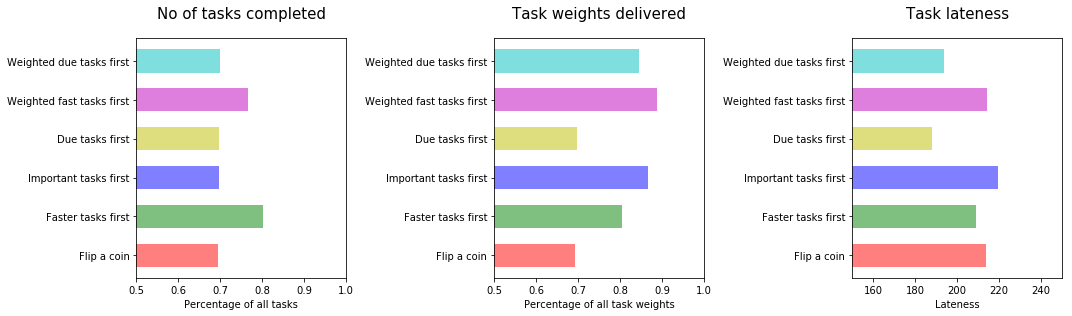

In [300]:
figure

# Pivot or Persevere? 

This is a questions many founders ask themselves -- should be try something else or should they keep going at what they're doing?

There is no best answer to this, but there is a common problem in probability theory called the _Multi-Armed Bandit_ that can give us an insight to this question.


# Multi-Armed Bandit

The name of the problem comes from (as with many probability problems) the casino, where a _one-armed bandit_ is a slot machine. 

A gambler facing a row of slot machines, must decide which slot machine to play at a time. Each slot machine that is being played has a probability of whether it will give a reward or not. The point of the gambler is of course to maximise his winnings. The trade-off is whether to _explore_, to try different slot machines to see if the probability is higher, or to _exploit_, which is to stick to the one the gambler thinks gives him the highest probability.

The same way, a founder facing multiple choices, must trade off whether she wants to explore different choices, or to exploit the best choice she currently has, given the limited time and resources.


In [29]:
from random import randint
from random import choice
import random as rnd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

# randomly choose 1 out of n
def flip(n): return randint(0,n-1)

def add(a, b): return list(map(lambda x, y: x + y, a, b))
def divide(a, b): return list([x/b for x in a])

    
# helper function to remove an element from a tuple
def remove(original_tuple, element_to_remove):
    new_tuple = []
    for s in list(original_tuple):
        if not (s == element_to_remove).all():
            new_tuple.append(s)
    return tuple(new_tuple)

# Our simulation

This simulation is a bit more involved. We will create a number of arms (slot machines) each with a probability distribution function. Each arm is a list of integers either 1 or 0. Each element represents one round of pulling the arm, with 1 representing a win and 0 representing a loss.

As before we will formulate a few algorithms and use them to play our arms, then try to determine how successful each of these algorithms are.


In [30]:
# create the arms
def create_arms(num, prob, size): 
    arms = []
    for i in range(num):
        p = [1-prob[i], prob[i]]
        a = np.random.choice([0, 1], size=size, p=p)
        arms.append(a)  
    return arms

# How to win

You would be consider a winner if your pulls get more wins than 75% of all the arms. For example, if there are 100 arms, each with 20 games (ie 10 integer lists of size 20), and the number of wins you get from our algorithm is better than 75 of these arms, our algorithm is considered to have won the round.


In [62]:
# check if the number of wins makes it the winner
def check_wins(wins, *arms):
    arm_wins= []
    for a in arms:
        arm_wins.append(sum(a))
        
    if wins > np.percentile(arm_wins, 75):
        return True
    else:
        return False


# Benchmark algorithms

Let's look at the benchmarks we'll be using. The simplest is to just stick to the same arm every game until the end of the round, which we call `stick_with_one`.

In [63]:
# stick with one arm only
def stick_with_one(*arms):   
    n = flip(len(arms))
    wins = sum(arms[n])       
    return check_wins(wins, *arms)    

# Flip a coin

Another simple algorithm is to randomly choose an arm to play each game which we call `flip_a_coin`.

In [64]:
# randomly choose an arm every round
def flip_a_coin(*arms):
    wins = 0  
    for i in range(len(arms[0])):
        n = flip(len(arms))        
        if arms[n][i] == 1:
            wins += 1
    return check_wins(wins, *arms)

# Let's play!

Now that we have the base algorithms, let's try to play using these algorithms and see how successful they are!

For this simulation we'll go with 1000 iterations, 20 arms and 50 games per round.

We'll also use a normal distribution for the arms.


In [65]:
iterations = 1000
num_arms = 20
size = 50

def normal_distribution(mean, variance):
    r = [rnd.normalvariate(mean, variance) for x in range(num_arms)]
    return divide(r,max(r)*1.1)


In [227]:
fn = [
    stick_with_one,
    flip_a_coin,
]

# arms probabilities using normal distribution
arm_prob = normal_distribution(0.5, 0.05)

final_results = [0] * len(fn)
results  = [0] * len(fn)
num_wins = [0] * len(fn)

# do this 1000 times
for i in range(iterations):
    # create the arms based on the given probability distribution
    arms = create_arms(num_arms, arm_prob, size)
    # for each algorithm, get the results of using the algorithm
    # and tally up the number of wins
    for n in range(len(fn)):
        results[n] = fn[n](*arms)
        if results[n]:       
            num_wins[n] += 1

for n in range(len(fn)):
    final_results[n] = num_wins[n]/(iterations)


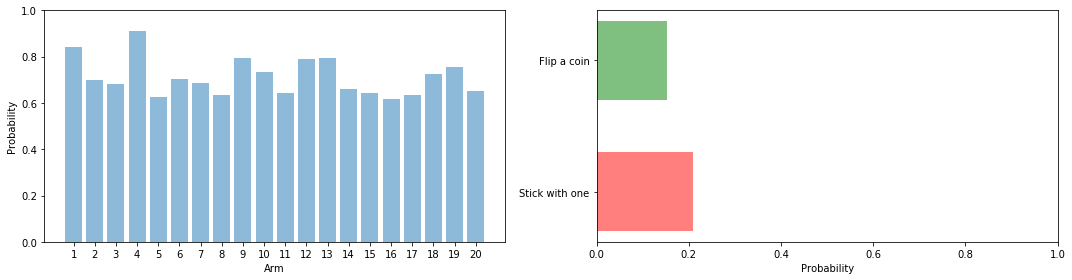

In [228]:
# Plotting the chart
%matplotlib inline
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
y_pos = np.arange(len(arm_prob))
plt.bar(y_pos, arm_prob, align='center', alpha=0.5, tick_label=range(1,len(arm_prob)+1))
plt.ylim([0,1.0])
plt.xlabel('Arm')
plt.ylabel('Probability')

plt.subplot(1, 2, 2)
labels = ('Stick with one', 'Flip a coin')
y_pos = np.arange(len(labels))
plt.barh(y_pos, final_results, 0.6, align='center', alpha=0.5, color='rgbymck')
plt.yticks(y_pos, labels)
plt.xlabel('Probability')
plt.xlim([0,1.0])
plt.tight_layout()
plt.show()

# Let's get a bit greedy

In the multi-armed bandit lingo, _explore_ means spending time to try different arms, and _exploit_ means figuring out the best arm and sticking to it.

_Flip A Coin_ is a pure _explore_ algorithm while _Stick to One_ is a pure _exploit_ algorithm. What happens if we mix them up and do a bit of both? The _Look Before You Leap_ algorithm (also known as the _e-greedy_ algorithm) is one such algorithm, where we spend `e` amount of time exploring and the rest of the time  exploiting the arms.

Let's see how we can simulate this with e = 0.1 or 10% of the games.

In [99]:
def look_before_leap(*arms):
    e = round(len(arms[0])*0.1)    
    wins = 0
    arm_wins, arm_plays = [0] * len(arms), [0] * len(arms)

    # Explore for the first e games
    for i in range(e):        
        n = flip(len(arms))
        arm_plays[n] += 1
        if arms[n][i] == 1:
            arm_wins[n] += 1
    
    # calculate the points for each arm to determine the best arm
    points = [0] * len(arms)
    for f in range(e):
        for g in range(len(arms)):
            if arm_plays[g] != 0:
                points[g] = arm_wins[g]/arm_plays[g]
        
    # get a list of best arms 
    k = [m for m, n in enumerate(points) if n == max(points)] 
    
    # if there are more than 1 best arm, flip for it
    # y is the index for the final winning arm
    y = 0
    if len(k) > 1:
        index = flip(len(k))
        y = k[index]
    else:
        y = k[0]    
    
    # Exploit for the rest of the games
    wins = arm_wins[y]
    for i in range(e, len(arms[0])):
        if arms[y][i] == 1:
            wins += 1
        
    return check_wins(wins, *arms)

In [225]:
fn = [
    stick_with_one,
    flip_a_coin,
    look_before_leap
]

# arms probabilities using normal distribution
arm_prob = normal_distribution(0.5, 0.05)

final_results = [0] * len(fn)
results  = [0] * len(fn)
num_wins = [0] * len(fn)

# do this 1000 times
for i in range(iterations):
    # create the arms based on the given probability distribution
    arms = create_arms(num_arms, arm_prob, size)
    # for each algorithm, get the results of using the algorithm
    # and tally up the number of wins
    for n in range(len(fn)):
        results[n] = fn[n](*arms)
        if results[n]:       
            num_wins[n] += 1

for n in range(len(fn)):
    final_results[n] = num_wins[n]/(iterations)


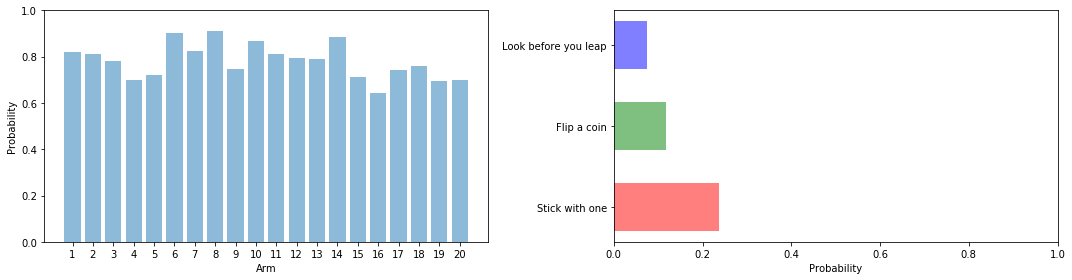

In [226]:
%matplotlib inline
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
y_pos = np.arange(len(arm_prob))
plt.bar(y_pos, arm_prob, align='center', alpha=0.5, tick_label=range(1,len(arm_prob)+1))
plt.ylim([0,1.0])
plt.xlabel('Arm')
plt.ylabel('Probability')

plt.subplot(1, 2, 2)
labels = ('Stick with one', 'Flip a coin', 'Look before you leap')
y_pos = np.arange(len(labels))
plt.barh(y_pos, final_results, 0.6, align='center', alpha=0.5, color='rgbymck')
plt.yticks(y_pos, labels)
plt.xlabel('Probability')
plt.xlim([0,1.0])
plt.tight_layout()
plt.show()

# Why is looking before you leap a bad strategy?

This seems pretty non-intuitive, but you should remember that the strategy for looking around is simply normalising the number of wins over the number of plays for each arm to see if that's a likely good arm.

Also, if you look at the distribution of probabilities in the arms, you can see that the probability variance between arms are not large, meaning the chances of winning with another arms is not much different. 

What happens if we make that variance much larger?

In [195]:
fn = [
    stick_with_one,
    flip_a_coin,
    look_before_leap
]

# arms probabilities using normal distribution
arm_prob = normal_distribution(0.5, 0.15)

final_results = [0] * len(fn)
results  = [0] * len(fn)
num_wins = [0] * len(fn)

# do this 1000 times
for i in range(iterations):
    # create the arms based on the given probability distribution
    arms = create_arms(num_arms, arm_prob, size)
    # for each algorithm, get the results of using the algorithm
    # and tally up the number of wins
    for n in range(len(fn)):
        results[n] = fn[n](*arms)
        if results[n]:       
            num_wins[n] += 1

for n in range(len(fn)):
    final_results[n] = num_wins[n]/(iterations)


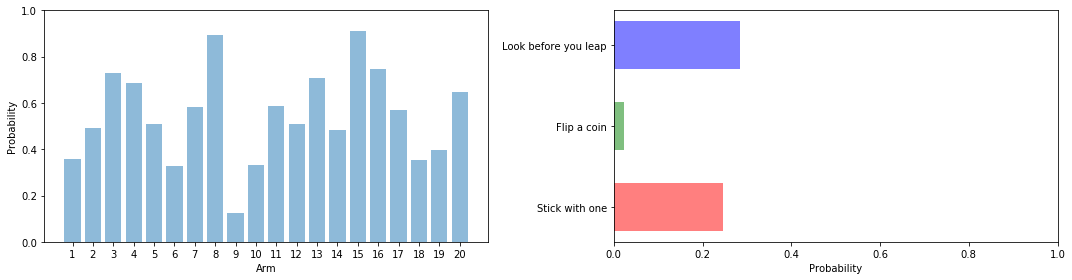

In [197]:
%matplotlib inline
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
y_pos = np.arange(len(arm_prob))
plt.bar(y_pos, arm_prob, align='center', alpha=0.5, tick_label=range(1,len(arm_prob)+1))
plt.ylim([0,1.0])
plt.xlabel('Arm')
plt.ylabel('Probability')

plt.subplot(1, 2, 2)
labels = ('Stick with one', 'Flip a coin', 'Look before you leap')
y_pos = np.arange(len(labels))
plt.barh(y_pos, final_results, 0.6, align='center', alpha=0.5, color='rgbymck')
plt.yticks(y_pos, labels)
plt.xlabel('Probability')
plt.xlim([0,1.0])
plt.tight_layout()
plt.show()

# How about if a few of the arms are a lot more likely to win than all others?

If this is the case, how does this affect the probabilities of these 3 algorithms?

To generate the large variance, we need to turn to another probabilty distribution -- the Pareto distribution (also known as the Power Law distribution).


In [189]:
fn = [
    stick_with_one,
    flip_a_coin,
    look_before_leap
]

def pareto_distribution(alpha):
    r = [rnd.paretovariate(alpha) for x in range(num_arms)]
    return divide(r,max(r)*1.1)

# arms probabilities using Power Law distribution
arm_prob = pareto_distribution(0.95)

final_results = [0] * len(fn)
results  = [0] * len(fn)
num_wins = [0] * len(fn)

# do this 1000 times
for i in range(iterations):
    # create the arms based on the given probability distribution
    arms = create_arms(num_arms, arm_prob, size)
    # for each algorithm, get the results of using the algorithm
    # and tally up the number of wins
    for n in range(len(fn)):
        results[n] = fn[n](*arms)
        if results[n]:       
            num_wins[n] += 1

for n in range(len(fn)):
    final_results[n] = num_wins[n]/(iterations)


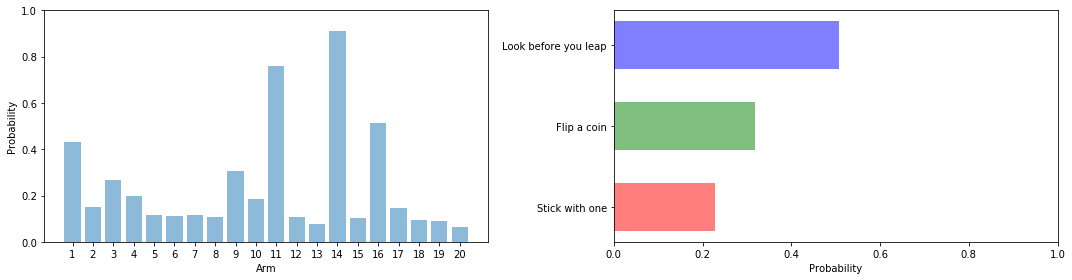

In [190]:
# Plotting the chart
%matplotlib inline
fig = plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
y_pos = np.arange(len(arm_prob))
plt.bar(y_pos, arm_prob, align='center', alpha=0.5, tick_label=range(1,len(arm_prob)+1))
plt.ylim([0,1.0])
plt.xlabel('Arm')
plt.ylabel('Probability')

plt.subplot(1, 2, 2)
labels = ('Stick with one', 'Flip a coin', 'Look before you leap')
y_pos = np.arange(len(labels))
plt.barh(y_pos, final_results, 0.6, align='center', alpha=0.5, color='rgbymck')
plt.yticks(y_pos, labels)
plt.xlabel('Probability')
plt.xlim([0,1.0])
plt.tight_layout()
plt.show()

# Make your own algorithms and play!

Feel free to modify the algorithms and/or create new algorithms and do your own simulation! Programming is fun!